# Chronos Test

In this example, we will test Chronos on canonical geoscientific data sets chosen to be representative of geoscience/geophysics:
1. earthquake catalogs from SoCal
2. earthquake ground motion waveforms
3. near surface properties (seismic velocities, temperature, soil moisture)
4. ice velocity from greenland
5. GPS positions along a plate boundary that captures seasons and tectonic loading

The data has been prepared as CSV files with times series.
The forescasts are added to the CSV files under key attributes "Chronos-zero-shot".

Limitations by [Chronos](https://arxiv.org/pdf/2403.07815). Chronos uses large language models at its core for forecasting time series. The time series is "tokenized" to convert from an array of floats into contect tokens.


By Marine Denolle (mdenolle@uw.edu)


In [8]:
import matplotlib.pyplot as plt
import torch
from chronos import ChronosPipeline
import pandas as pd
import numpy as np

In [9]:
context_length = 128
prediction_length = 16

In [10]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

## Load data

1. Earthquake catalogs

In [11]:
# first we load data/data_qtm_catalog.csv
df = pd.read_csv("../data/data_qtm_catalog.csv")
df.head()

,datetime,count
0,2008-01-01,120
1,2008-01-02,89
2,2008-01-03,146
3,2008-01-04,166
4,2008-01-05,94


In [12]:
# calculate the time difference between each datetime to set up the dt
# convert the datetime column to datetime object
df["datetime"] = pd.to_datetime(df["datetime"])
dt = df["datetime"].diff().dt.total_seconds().fillna(0).mean()
# convert seconds to days
dt = np.ceil(dt / (60 * 60 * 24))
print(dt)

1.0


In [13]:
n_timeseries = 5

In [14]:
# select a random start date from the data frame to generate a 2-year time series from the catalog. Make 20 examples of 2-year time series.
# we will make a list of 20 dictionaries, each dictionary will have a start date and a time series
# initialize a list of 20 dictionaries
df_list = [pd.DataFrame() for _ in range(n_timeseries)]
for ik in range(n_timeseries):
    start_date = df["datetime"].sample().values[0]
    start_date = pd.to_datetime(start_date)
    print(start_date)
    # create a time series for the next 2 years
    end_date = start_date + pd.DateOffset(years=2)
    # create a time series from the catalog
    time_series = df[(df["datetime"] >= start_date) & (df["datetime"] <= end_date)]
    time_series = time_series.set_index("datetime")
    time_series = time_series.resample(f"{dt}D").mean().interpolate()
    time_series = time_series.fillna(method="ffill")
    time_series = time_series.fillna(method="bfill")
    time_series = time_series.reset_index()
    df_list[ik] = time_series


2015-06-04 00:00:00
2013-10-01 00:00:00
2009-03-14 00:00:00
2012-11-07 00:00:00
2017-03-24 00:00:00


/var/folders/j4/3rbzxjb16kv66g_p4wkzq16h0000gn/T/ipykernel_6838/1672676439.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method="ffill")
/var/folders/j4/3rbzxjb16kv66g_p4wkzq16h0000gn/T/ipykernel_6838/1672676439.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method="bfill")
/var/folders/j4/3rbzxjb16kv66g_p4wkzq16h0000gn/T/ipykernel_6838/1672676439.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method="ffill")
/var/folders/j4/3rbzxjb16kv66g_p4wkzq16h0000gn/T/ipykernel_6838/1672676439.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill()

In [15]:
# take each "count" column from the 20 dataframes and assemble a single wide dataframe ith all the columns
# initialize a list of 20 dataframes
df_list_count = [pd.DataFrame() for _ in range(n_timeseries)]
for ik in range(n_timeseries):
    df_list_count[ik] = df_list[ik]["count"]
    df_list_count[ik] = df_list_count[ik].rename(f"{ik}")
df_wide = pd.concat(df_list_count, axis=1)
# add a first column with a date that is the same for all the 20 time series
df_wide["datetime"] = np.arange(0, len(df_wide)) * pd.Timedelta(days=dt)
# convert datetime to integer
df_wide["datetime"] = df_wide["datetime"].dt.days
# move the last column to the first position
cols = df_wide.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_wide = df_wide[cols]
df_wide.head()


IndexError: list index out of range

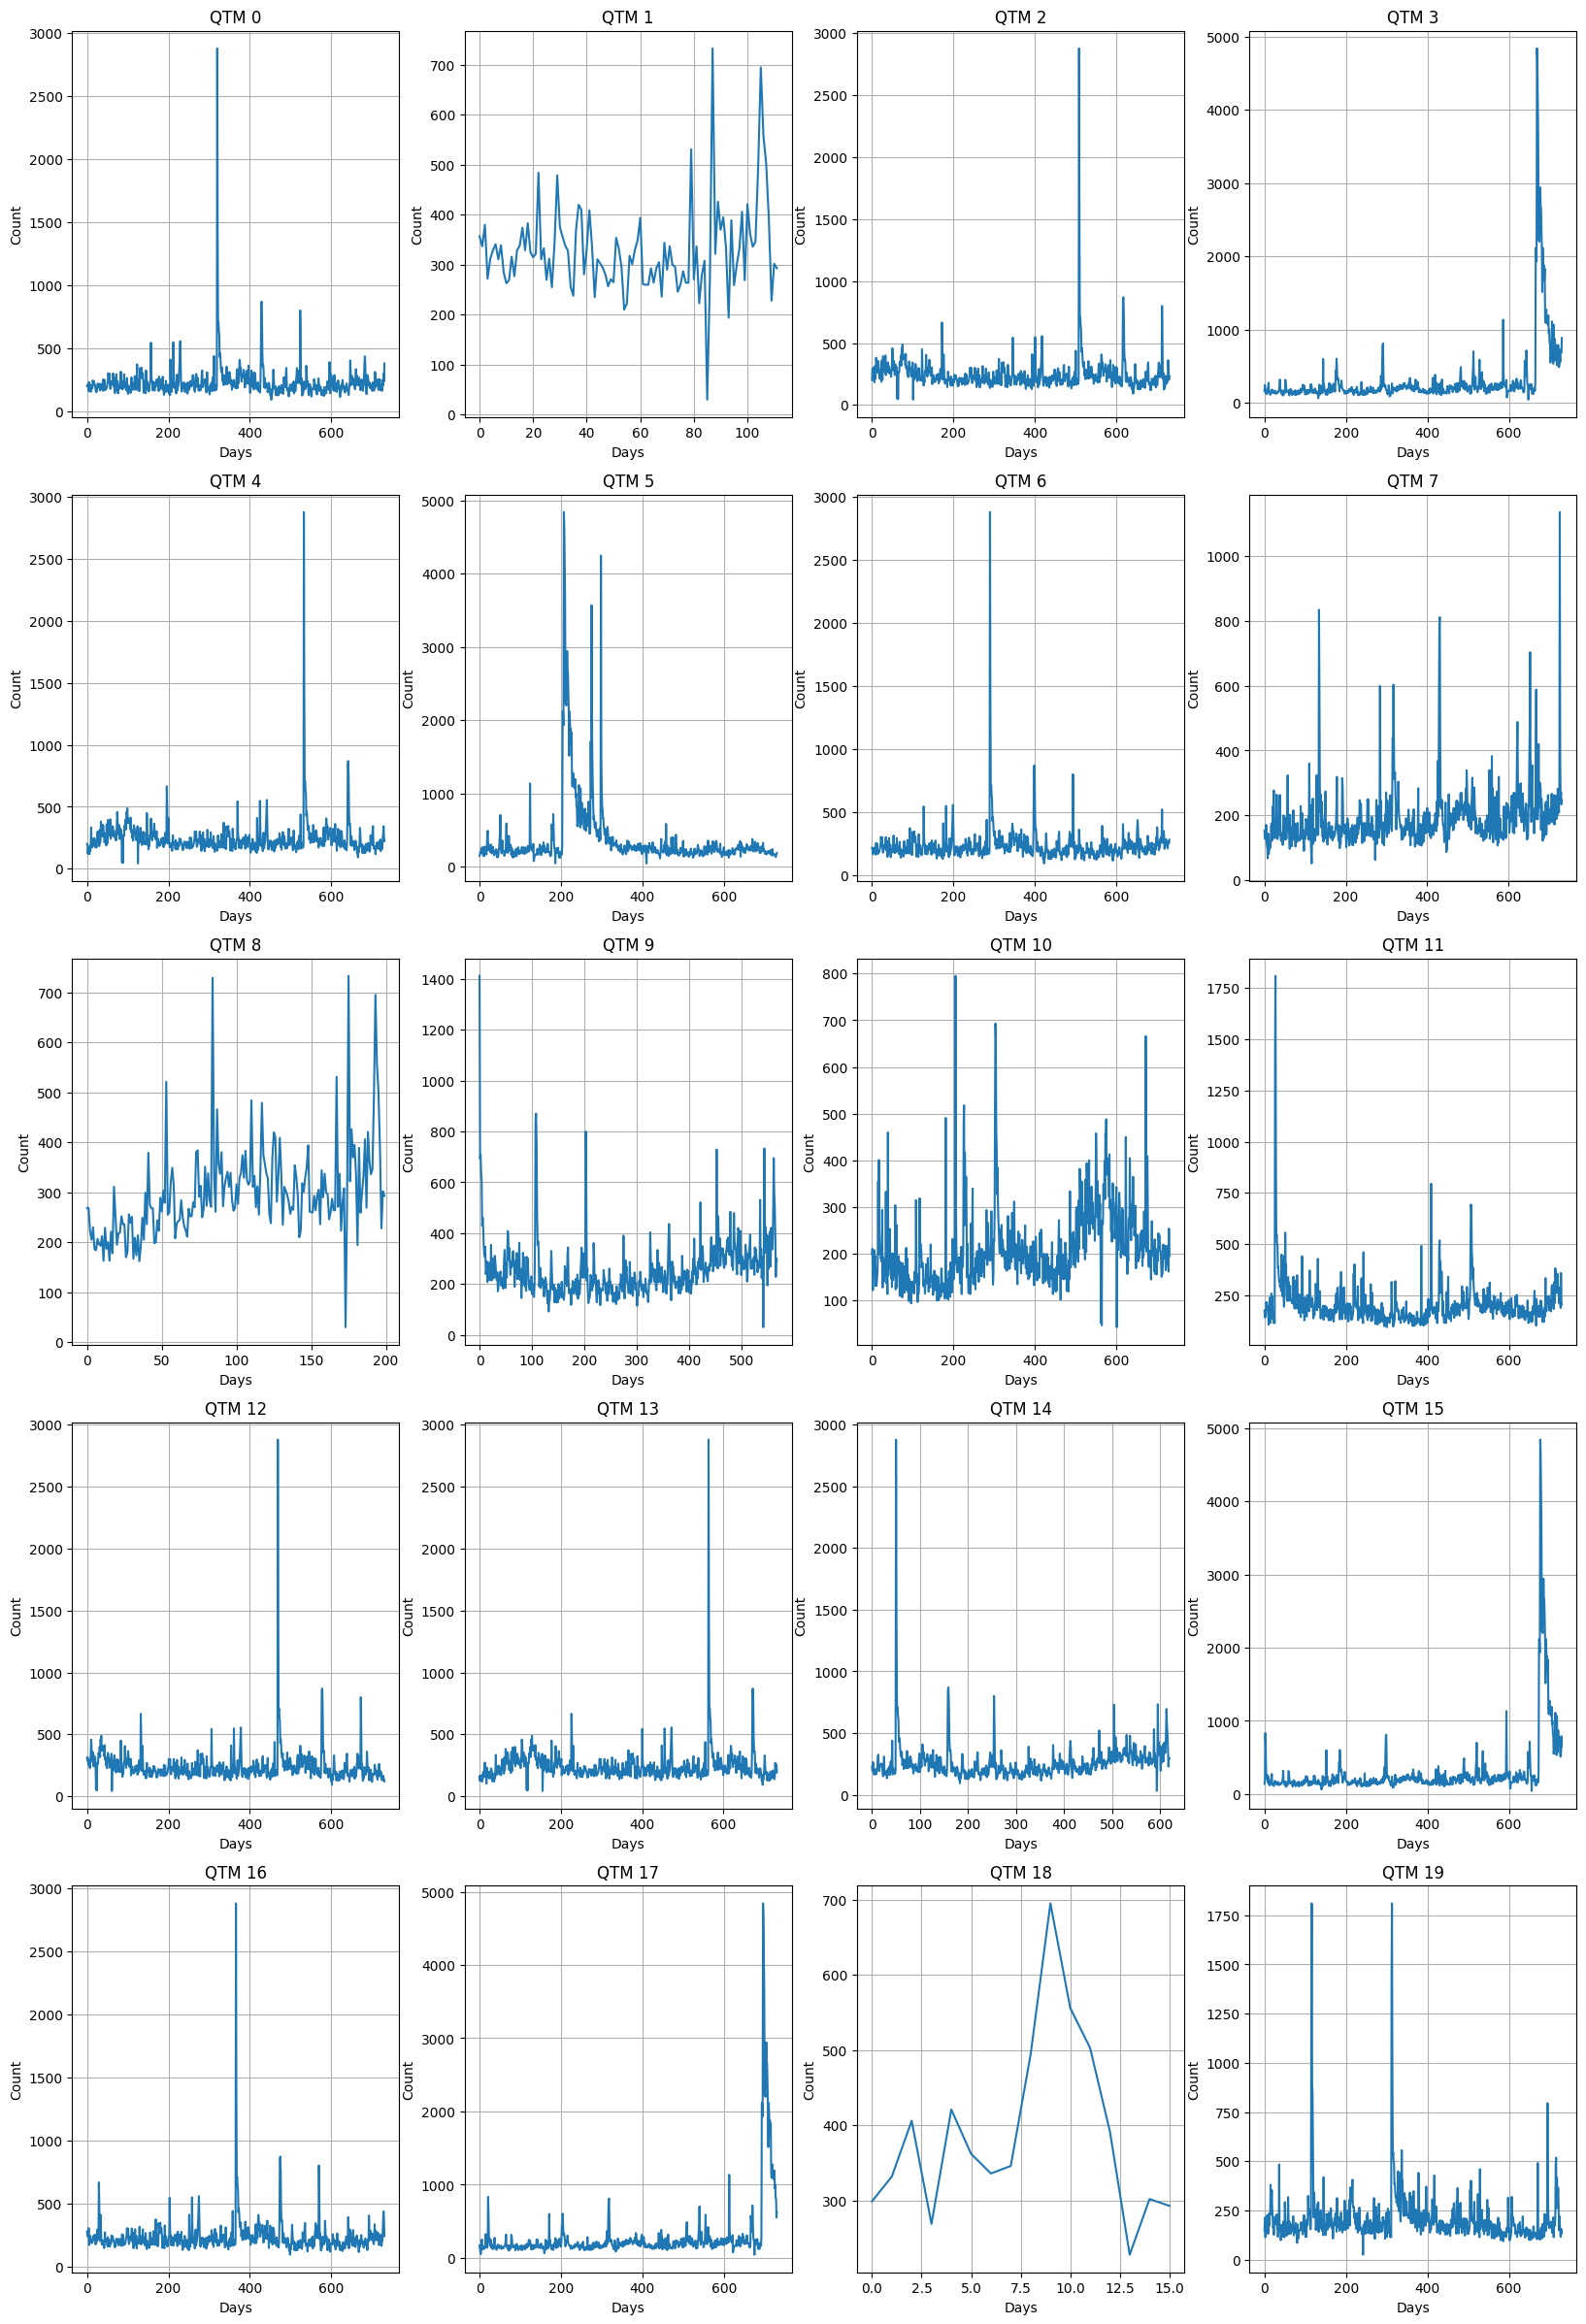

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 30))  # define the figure and subplots
axes = axes.ravel()
for i in range(n_timeseries):
    ax = axes[i]
    ax.plot(df_wide["datetime"], df_wide[f"{i}"])
    ax.set_title(f"QTM {i}")
    ax.set_xlabel("Days")
    ax.set_ylabel("Count")
    ax.grid()

In [ ]:
# generate batch predictions
# 
# # Define the percentage of data to be used for training
alpha = 0.05  # Example: use 95% of the data for context (= training) and 5% for prediction ( = evaluation) 

# Select the first n_timeseries columns for forecasting
columns_to_forecast = df_wide.columns[1:n_timeseries+1]  # +1 to skip the 'Date' column

# Calculate the split index for training
split_index = int(len(df_wide) * (1 - alpha))

# Split the data into training and evaluation sets for all selected columns
train_data = df_wide[columns_to_forecast].iloc[:split_index]
eval_data = df_wide[columns_to_forecast].iloc[split_index:]
print(train_data.shape, eval_data.shape)
# Convert the training data to a higher-dimensional tensor
train_tensor = torch.tensor(train_data.values, dtype=torch.float32).T

# Perform the forecasting using the training data
forecast = pipeline.predict(
    context=train_tensor,
    prediction_length=len(eval_data),  # Predict the same length as the evaluation set
    num_samples=50,
)

# Take the mean across the samples (axis=1) for each time series
forecast_mean = forecast.mean(dim=1).squeeze()


(695, 20) (37, 20)


In [ ]:
mae=[]
# Calculate and print the MAE for each time series
for i, column_name in enumerate(columns_to_forecast):
    # Calculate MAE for the current time series
    mae.append (np.mean(np.abs(forecast_mean[i].numpy() - eval_data[column_name].values)))
    
    # Print the MAE
    # print(f'Mean Absolute Error (MAE) for {column_name}: {mae[-1]}')

print(f'Mean of forecast MAEs = {np.array(mae).mean()}')

mae_nochangemodel=[]
# Calculate and print the MAE for each time series
for i, column_name in enumerate(columns_to_forecast):
    # Calculate MAE for the current time series
    mae_nochangemodel.append (np.mean(np.abs(eval_data[column_name].values[-1] - eval_data[column_name].values)))
    
    # Print the MAE
    # print(f'MAE assuming d/dt=0 for {column_name}: {mae_nochangemodel[-1]}')

print(f'Mean of d/dt=0 MAEs = {np.array(mae_nochangemodel).mean()}')

Mean of forecast MAEs = nan
Mean of d/dt=0 MAEs = nan


## 2. Icesheet velocities

Now we test the time series of icesheet velocities in Greenland. This is work done by Brad Lipovsky.

In [ ]:

'''
Read the data
'''
df = pd.read_csv('../data/data_ice_jakobshavn.csv',na_values=[-1])


In [ ]:
# Ensure df['Date'] is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Define the percentage of data to be used for training
alpha = 0.01  # Example: use 95% of the data for training and 5% for evaluation

# Number of time series to forecast
n_timeseries = 100  # You can set this to the number of columns you want to forecast

# Select the first n_timeseries columns for forecasting
columns_to_forecast = df.columns[1:n_timeseries+1]  # +1 to skip the 'Date' column

# Calculate the split index for training
split_index = int(len(df) * (1 - alpha))

# Split the data into training and evaluation sets for all selected columns
train_data = df[columns_to_forecast].iloc[:split_index]
eval_data = df[columns_to_forecast].iloc[split_index:]

# Convert the training data to a higher-dimensional tensor
train_tensor = torch.tensor(train_data.values, dtype=torch.float32).T

# Perform the forecasting using the training data
forecast = pipeline.predict(
    context=train_tensor,
    prediction_length=len(eval_data),  # Predict the same length as the evaluation set
    num_samples=50,
)

# Take the mean across the samples (axis=1) for each time series
forecast_mean = forecast.mean(dim=1).squeeze()

In [ ]:
mae=[]
# Calculate and print the MAE for each time series
for i, column_name in enumerate(columns_to_forecast):
    # Calculate MAE for the current time series
    mae.append (np.mean(np.abs(forecast_mean[i].numpy() - eval_data[column_name].values)))
    
    # Print the MAE
    # print(f'Mean Absolute Error (MAE) for {column_name}: {mae[-1]}')

print(f'Mean of forecast MAEs = {np.array(mae).mean()}')

mae_nochangemodel=[]
# Calculate and print the MAE for each time series
for i, column_name in enumerate(columns_to_forecast):
    # Calculate MAE for the current time series
    mae_nochangemodel.append (np.mean(np.abs(eval_data[column_name].values[-1] - eval_data[column_name].values)))
    
    # Print the MAE
    # print(f'MAE assuming d/dt=0 for {column_name}: {mae_nochangemodel[-1]}')

print(f'Mean of d/dt=0 MAEs = {np.array(mae_nochangemodel).mean()}')

In [ ]:
# Determine the layout: 4 rows by 2 columns
nrows, ncols = 4, 3

# Create a nrows-by-ncols grid of subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 18), sharex=True)

# Flatten the 2D array of axes for easy indexing
axes = axes.flatten()

# Iterate over the first n_timeseries and plot
for i, column_name in enumerate(columns_to_forecast[0:12]):
    # Plot the original data
    axes[i].plot(df['Date'], df[column_name], label='Original Data')
    
    # Calculate the 5th and 95th percentiles for the confidence interval
    lower_bound = np.percentile(forecast[i, :, :].numpy(), 5, axis=0)
    upper_bound = np.percentile(forecast[i, :, :].numpy(), 95, axis=0)
    
    # Plot the forecast
    axes[i].plot(df['Date'].iloc[split_index:], forecast_mean[i].numpy(), label='Forecast')
    
    # Plot the confidence intervals
    axes[i].fill_between(df['Date'].iloc[split_index:], lower_bound, upper_bound, 
                         color='r', alpha=0.2, label='95% CI')

    # Plot the evaluation data for reference
    axes[i].plot(df['Date'].iloc[split_index:], eval_data[column_name].values, '--', label='Evaluation Data')

    # Format the subplot
    axes[i].set_title(f'{column_name}, MAE={mae[i]:.2f} m/a')
    axes[i].set_ylabel('Speed (m/a)')
    axes[i].grid(True)
    axes[i].legend()

    # Apply x-tick rotation
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplots if n_timeseries < 8
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('jakobshavn-forecast.png')
plt.show()

## 3. Forecasting GPS velocities

In this case, we are going to test Chrono's performance on GPS time series. Vertical components tend to exhibit seasonal loading from precipitation, horizontal components tend to exhibit tectonic processes, especially at plate boundaries.

In [ ]:
# read data from data_gps_P395_relateive_position.csv
df = pd.read_csv("../data/data_gps_P395_relateive_position.csv")
# the date format is in decimal years, convert it to datetime
df["Date"] = pd.to_datetime(df["Date"], format="%Y.%j")
df.head()